# Weather Forecast - Modelling

## Import Data for Modelling

Import Libraries

In [37]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

ERROR! Session/line number was not unique in database. History logging moved to new session 159


Importing Data

In [2]:
filename = 'modelling_data.csv'
data_df = pd.read_csv(filename)
data_df.head()

,Date,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
0,2018-01-01,1019.5,16.3,26.1,25.333333,9.666667
1,2018-01-02,1019.6,16.1,27.4,27.583333,12.000000
2,2018-01-03,1019.9,15.7,27.2,24.416667,11.666667
3,2018-01-04,1021.4,16.0,29.0,27.166667,12.333333
4,2018-01-05,1021.2,14.2,26.9,29.916667,12.333333


Computing the Mean Temperature

In [3]:
data_df['Mean Temperature'] = pd.Series(np.mean([data_df['Minimum Temperature'], data_df['Maximum Temperature']], axis=0))
data_df.head()

,Date,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed,Mean Temperature
0,2018-01-01,1019.5,16.3,26.1,25.333333,9.666667,21.20
1,2018-01-02,1019.6,16.1,27.4,27.583333,12.000000,21.75
2,2018-01-03,1019.9,15.7,27.2,24.416667,11.666667,21.45
3,2018-01-04,1021.4,16.0,29.0,27.166667,12.333333,22.50
4,2018-01-05,1021.2,14.2,26.9,29.916667,12.333333,20.55


In [4]:
data_df.shape

(1096, 7)

## LSTM - Weather Forecasting

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Bidirectional, Conv1D

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import mean_squared_error

from keras.layers import ConvLSTM2D

Using TensorFlow backend.


Convert DataFrame to Numpy Array

In [6]:
date_series = data_df['Date']
data_array = data_df.iloc[:, 1:].values
data_array.shape, data_array.dtype, date_series.shape

((1096, 6), dtype('float64'), (1096,))

Scaling of Dataset to avoid gradient explosion. 

__N.B:__ One importance of fit-transform is that the scaling can easily be inverted.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data_array)
data_array = scaler.transform(data_array)
data_array.shape, data_array.dtype

((1096, 6), dtype('float64'))

Preparing the training and testing data for LSTM

In [8]:
def train_test_data_for_lstm(data, n_past, n_future=1, view_shape=False):
    """
    Function to determine the training and testing data for a recurrent neural network modelling.
    
    Input:
    data - numpy array of the data to be modelled
    n-past - the number of days in the past to be utilised for modelling
    n-future - the date in the future to be predicted.
    
    Output:
    trainX - the training features
    trainY - the training targets
    """
    
    # Define list to store training and testing datasets
    X = []
    Y = []
    
    for i in range(n_past, len(data) - n_future +1):
        X.append(data[i - n_past:i, 0:data.shape[1] - 1])
        Y.append(data[i + n_future - 1:i + n_future, data.shape[1] - 1])

    X, Y = np.array(X), np.array(Y)
    
    if view_shape:
        print('trainX shape == {}.'.format(X.shape))
        print('trainY shape == {}.'.format(Y.shape))
        
    return X, Y   

In [9]:
trainX, trainY = train_test_data_for_lstm(data_array, 28, 1, True)

trainX shape == (1068, 28, 5).
trainY shape == (1068, 1).


In [10]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 64)            17920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [50]:
weather_model = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Train on 961 samples, validate on 107 samples
Epoch 1/5
961/961 [==============================] - 5s 5ms/step - loss: 0.0115 - val_loss: 0.0052
Epoch 2/5
961/961 [==============================] - 4s 5ms/step - loss: 0.0111 - val_loss: 0.0065
Epoch 3/5
961/961 [==============================] - 4s 4ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 4/5
961/961 [==============================] - 4s 4ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 5/5
961/961 [==============================] - 5s 5ms/step - loss: 0.0113 - val_loss: 0.0088


Plot the graph of the training loss and the validation loss for the developed model.

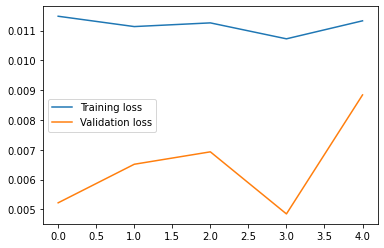

In [51]:
plt.plot(weather_model.history['loss'], label='Training loss')
plt.plot(weather_model.history['val_loss'], label='Validation loss')
plt.legend()

### Forecasting

In [58]:
n_future = 365
forecast_dates = pd.date_range(list(date_series)[-1], periods=n_future, freq='1d')

forecast = model.predict(trainX[-n_future:])

forecast_copies = np.repeat(forecast, data_array.shape[1], axis=1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:, -1]

C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Olanrewaju Farooq\.conda\envs\envTensorFlow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will

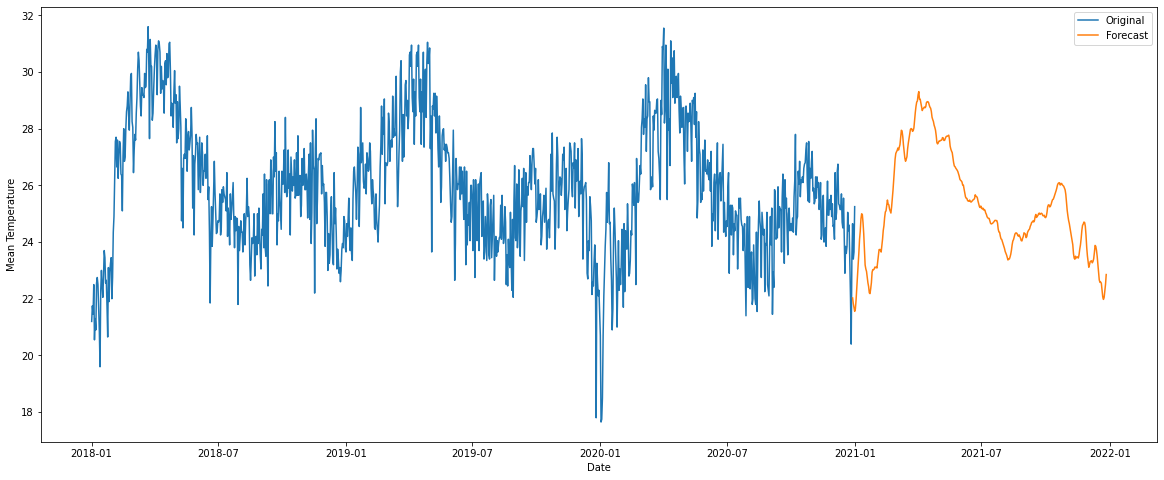

In [57]:
before_predict_df = data_df[['Date', 'Mean Temperature']]
predict_df = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Temperature':y_pred_future})

before_predict_df['Date'] = pd.to_datetime(before_predict_df['Date'])
predict_df['Date'] = pd.to_datetime(predict_df['Date'])

plt.figure(figsize=(20, 8))
sb.lineplot(before_predict_df['Date'], before_predict_df['Mean Temperature'])
sb.lineplot(predict_df['Date'], predict_df['Mean Temperature'])
plt.legend(['Original', 'Forecast'])